In [6]:
# Make sure these libraries are installed on local computer
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
#from qiskit.providers.ibmq import least_busy

import cv2
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

import os
import math

# Resource Estimation
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from qiskit.compiler import transpile
from time import perf_counter

# Detection algorithm works with an NxN matrix
#N is a power of 2
N = 32

#Name the image
name = "Sunny_Capybara"

#Path of image to use
# path = os.path.join("test_images", "squarecapybara.jpg")
path = os.path.join("timothycapybara.png")
# path = os.path.join("test_images", "fire.png")
# path = os.path.join("test_images", "flower.png")
# path = os.path.join("test_images", "bulb.png")
# path = os.path.join("test_images", "gradient.png")

In [7]:
def plot_image(img, title: str):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [8]:
def RMS(img_data):
    return np.sqrt(np.sum(img_data**2))

In [9]:
def amplitude_encode(img_data):
    # Calculate the RMS value
    rms = np.sqrt(np.sum(img_data**2))
    #Edge case: All zeroes
    if rms == 0:
        rms = np.sqrt(N * N * 1e-30)
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(max(ele, 1e-15) / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [10]:
#Input Processing to np array

img_raw = np.asarray(Image.open(path), dtype=int)
# img_raw = plt.imread('/test_images/test_image1.jpg')

n = img_raw.shape[0]
m = img_raw.shape[1]
#n, m, k = img_raw.shape

print('Raw Image info:', img_raw.shape)
print('Raw Image datatype:', img_raw.dtype)

if n != m:
    raise Exception("Image must be square")

if n % N != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} matrix")

# we need to "reduce" each sz X sz grid
# sz is size
sz = n // N


Raw Image info: (32, 32, 4)
Raw Image datatype: int32


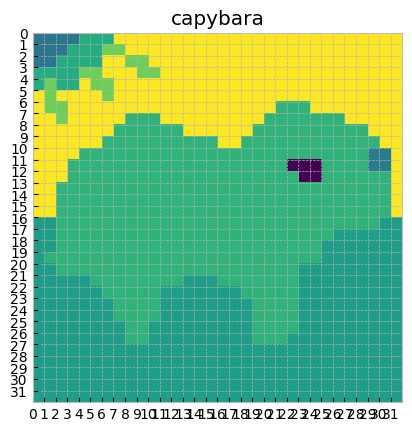

In [11]:
img = np.zeros(shape=(N, N))

for i in range(0, n, sz):
    for j in range(0, n, sz):
        #This will be a single cell in final pixel - use average
        val = np.sum(img_raw[i:i+sz, j:j+sz][0]) / sz / sz
        img[i//sz][j//sz] = val

plot_image(img, "capybara")

In [12]:
# Horizontal: Original image
image_norm_h = amplitude_encode(img)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(img.T)

In [13]:
# qubit amount
# data_qb should be math.ceil(math.log2(N))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

print(total_qb)

11


C:\Users\shrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


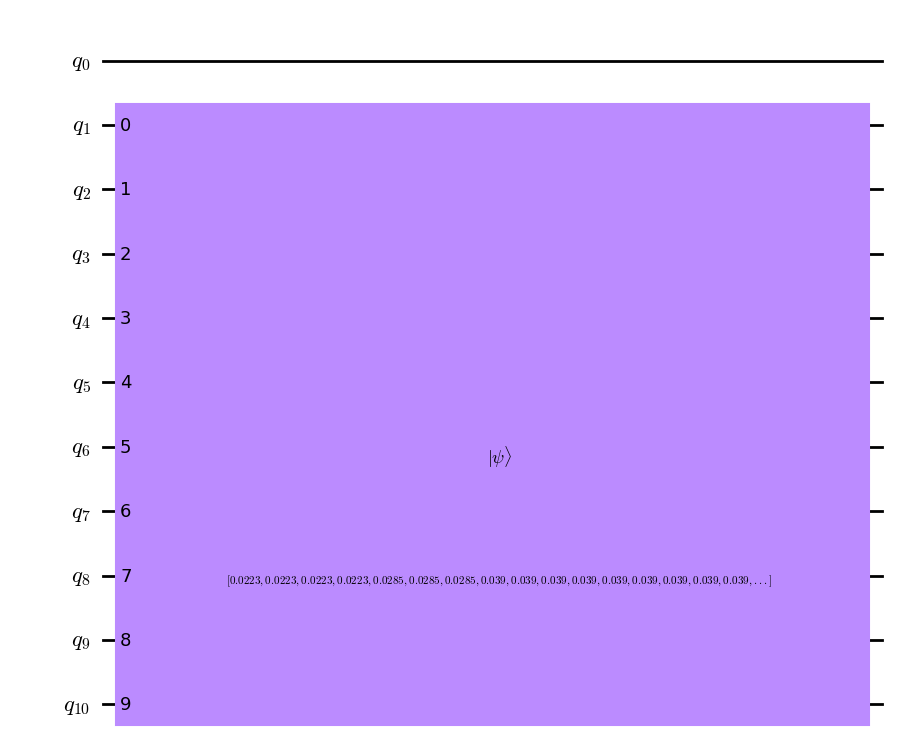

In [14]:
# horizontal scan circuit
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
display(qc_h.draw('mpl', fold=-1))

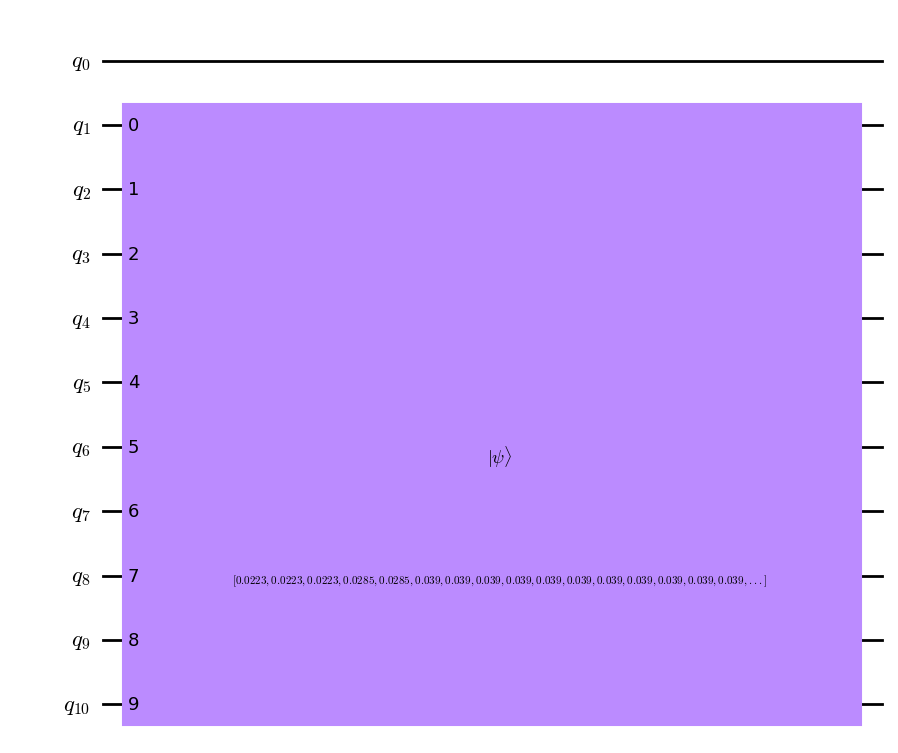

In [15]:
# vertical scan circuit
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
display(qc_v.draw('mpl', fold=-1))

In [16]:
# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

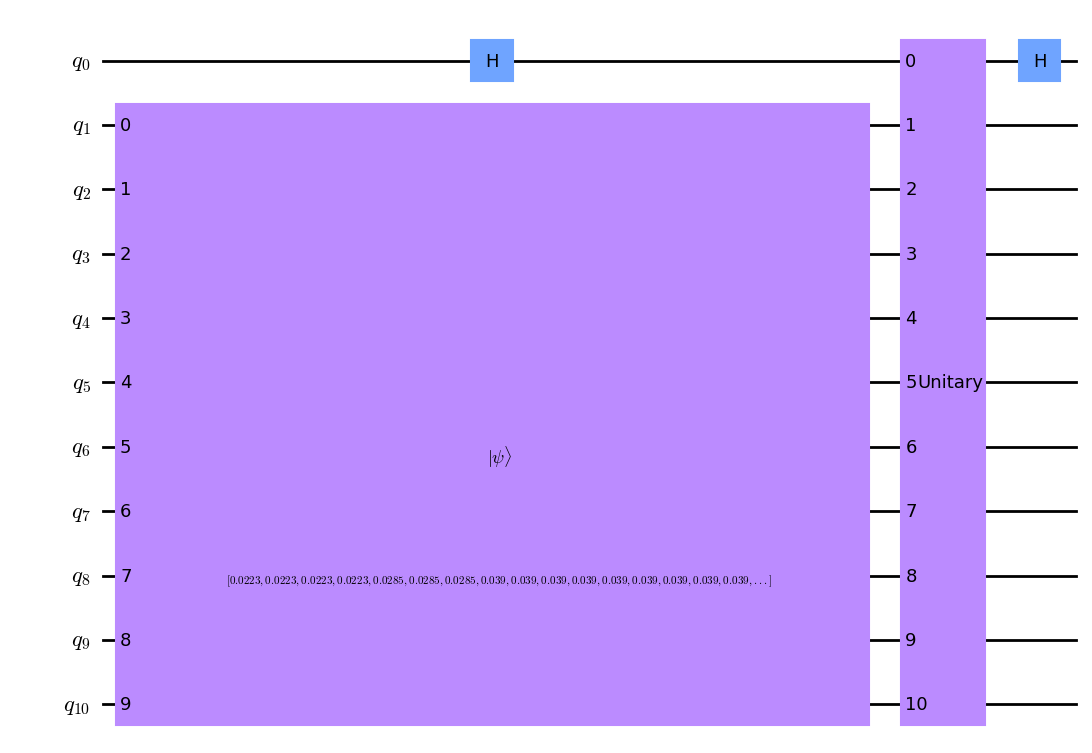

In [17]:
#QHED for horizontal scan circuit
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

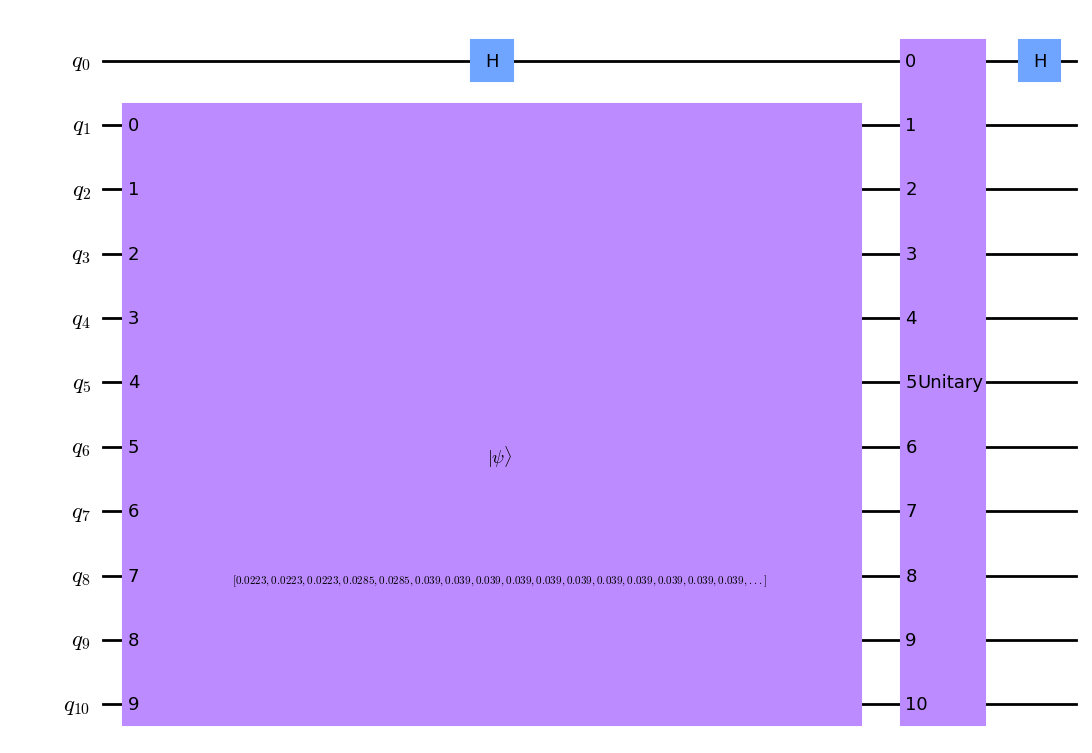

In [18]:
#QHED for vertical scan circuit
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

In [19]:
# Store both circuits in a list, so we can run both circuits in one simulation later
circ_list = [qc_h, qc_v]

In [20]:
# Simulating the circuits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

8.192149763520472e-19


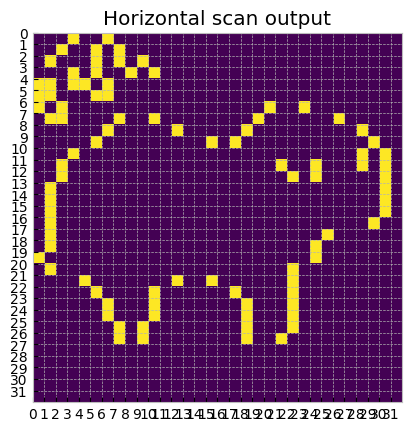

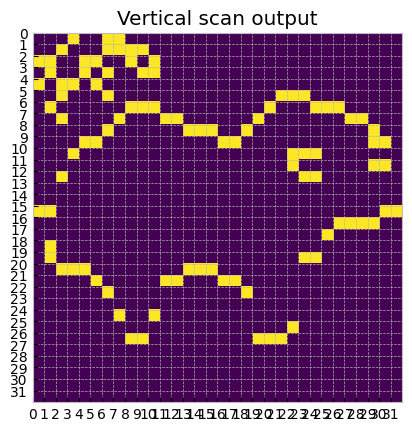

Text(0, 0.5, 'Frequency')

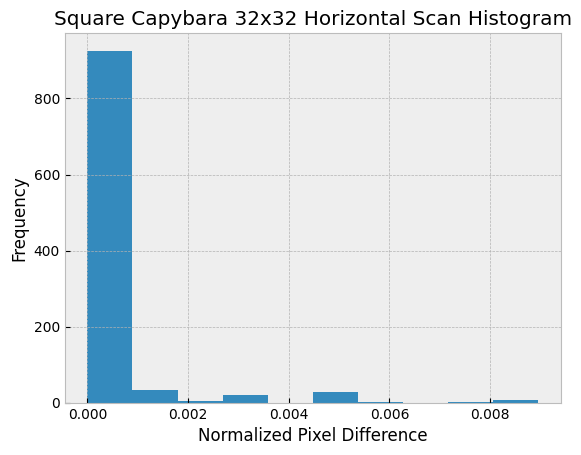

In [21]:
# Classical postprocessing for plotting the output

percent_edges = 0.2

# #Max adaptive thresholding
# thresh = np.max(np.array([np.abs(sv_h[2*i+1].real) for i in range(N*N)])) * (1 - percent_edges)

#K-Best adaptive thresholding
thresh = np.sort(np.array([np.abs(sv_h[2*i+1].real) for i in range(N*N)]))[int(N * N * (1 - percent_edges))]
print(thresh)

# Defining a lambda function for thresholding difference values
threshold = lambda amp: (amp > thresh or amp < -1 * thresh)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix

edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) and (i + 1) % N != 0 else 0 for i in range(N*N)])).reshape(N, N)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) and (i + 1) % N != 0 else 0 for i in range(N*N)])).reshape(N, N).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

plt.hist(
    np.array(
        [np.abs(sv_h[2*i+1].real) for i in range(N*N)]
    )
)

plt.title("Square Capybara 32x32 Horizontal Scan Histogram")
plt.xlabel("Normalized Pixel Difference")
plt.ylabel("Frequency")
# plt.hist(
#     np.array(
#         [np.abs(sv_h[2*i+1].real) for i in range(N*N)]
#     )
# )

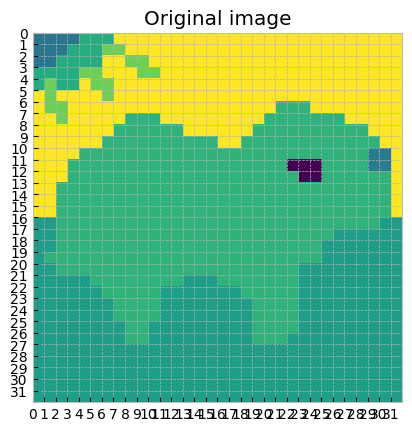

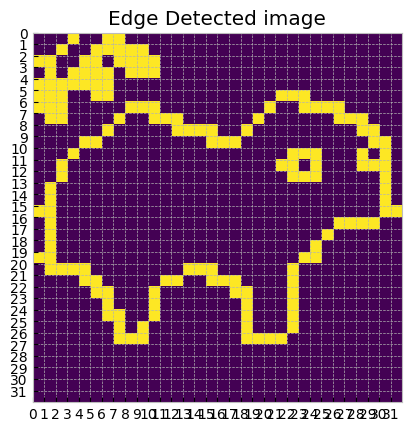

In [22]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(img, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')